In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
plt.rcParams['figure.figsize'] = [13, 11]

In [2]:
# Parse config.txt file
# the first line is the number of entries
# then each line is the fitting result with params a,b,c,d,mean,std
# then there is a line for the number of data points in the fit
# each line is a data point x,y
def parse_config(filename):
    with open(filename) as f:
        num_entries = int(f.readline())
        entries = []
        for i in range(num_entries):
            line = f.readline()
            entry = line.split(',')
            # add tuple (params, mean, std)
            entries.append((list(map(float,entry[0:-2])), float(entry[-2]), float(entry[-1])))
        data = []
        for i in range(num_entries):
            num_data_points = int(f.readline())
            data_points = []
            for i in range(num_data_points):
                line = f.readline()
                x,y = line.split(',')
                data_points.append((float(x),float(y)))
            data_points.sort(key=lambda x: x[1])
            data.append(data_points)
        return entries, data

config = parse_config("config.txt")

In [27]:
def calculate_R(u, E=3.3, Rf=47*10**3):
    return u*Rf/(E-u)

def calculate_u(R, E=3.3, Rf=47*10**3):
    return E*R/(Rf+R)

def calculate_Rtot_err(R_err, Rf_err):
    return np.sqrt(R_err**2 + Rf_err**2)

def calculate_u_err(u, R_precision, Rf_precision,E=3.3, Rf=47*10**3):
    R = calculate_R(u, E, Rf)
    R_err = R * R_precision / 100
    Rf_err = Rf * Rf_precision / 100
    return np.abs(u) * np.sqrt((R_err/(R*E))**2 + (calculate_Rtot_err(R_err, Rf_err)/(Rf+R))**2)

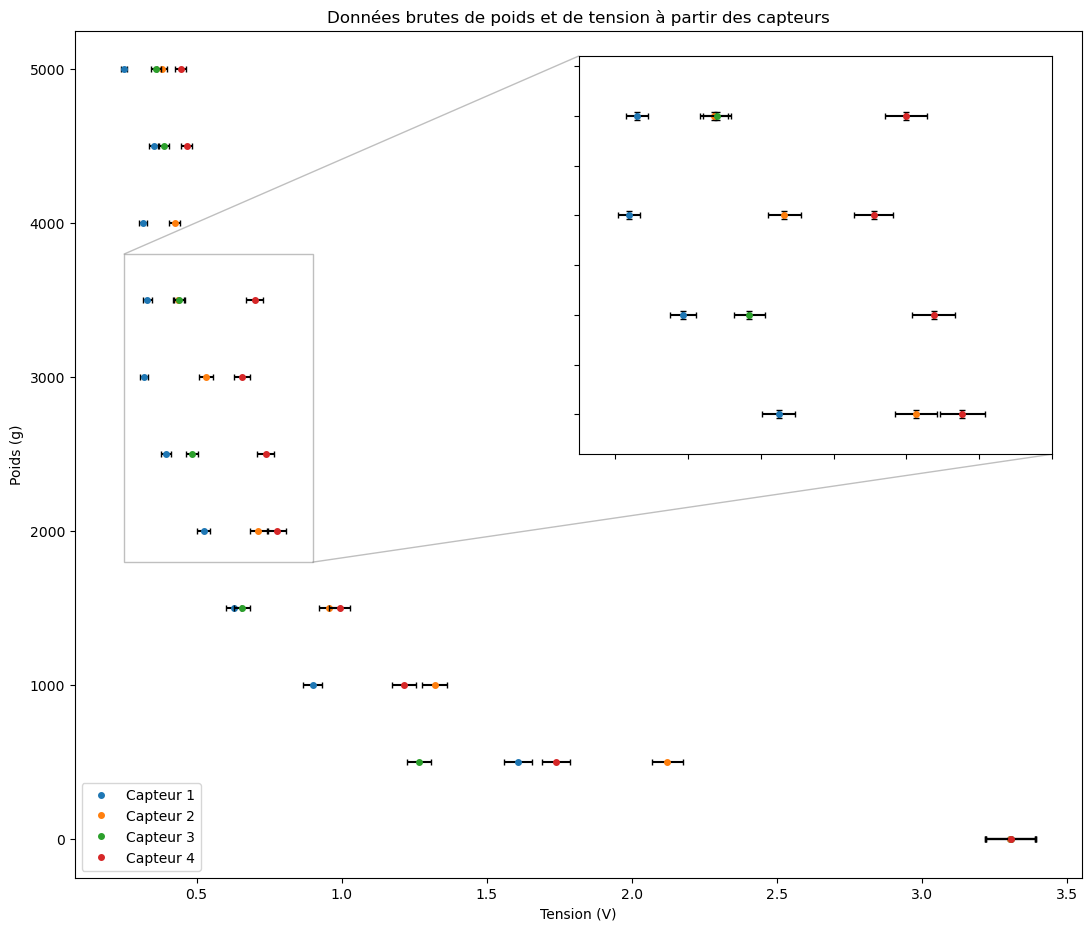

In [126]:
# Plot the data points
def plot_data(data):
    fig, ax = plt.subplots()

    for i in range(len(data)):
        x = [d[0] for d in data[i]]
        y = [d[1] for d in data[i]]

        xerr = calculate_u_err(np.array(x), 2.5, 5)

        ax.errorbar(x,y, xerr=xerr, fmt='none', ecolor='black', capsize=2)
        ax.plot(x,y,'o', label='Capteur {}'.format(i+1), markersize=4)
        ax.set_xlabel('Tension (V)')
        ax.set_ylabel('Poids (g)')


        # Zoom on region of interest using inset axes
    axins = ax.inset_axes([0.5, 0.5, 0.47, 0.47])
    x_min = 0.25
    x_max = 0.9

    for i in range(len(data)):
        x = [d[0] for d in data[i]]
        y = [d[1] for d in data[i]]
        xerr = calculate_u_err(np.array(x), 2.5, 5)

        axins.errorbar(x,y, xerr=xerr, yerr=20,fmt='none', ecolor='black', capsize=2)
        axins.plot(x,y,'o', label='Capteur {}'.format(i+1), markersize=4)




    axins.set_xlim(x_min, x_max)

    axins.set_ylim(1800, 3800)
    axins.set_xticklabels('')
    axins.set_yticklabels('')
    ax.indicate_inset_zoom(axins)


    plt.legend()
    plt.title("Données brutes de poids et de tension à partir des capteurs")
    plt.show()

plot_data(config[1])


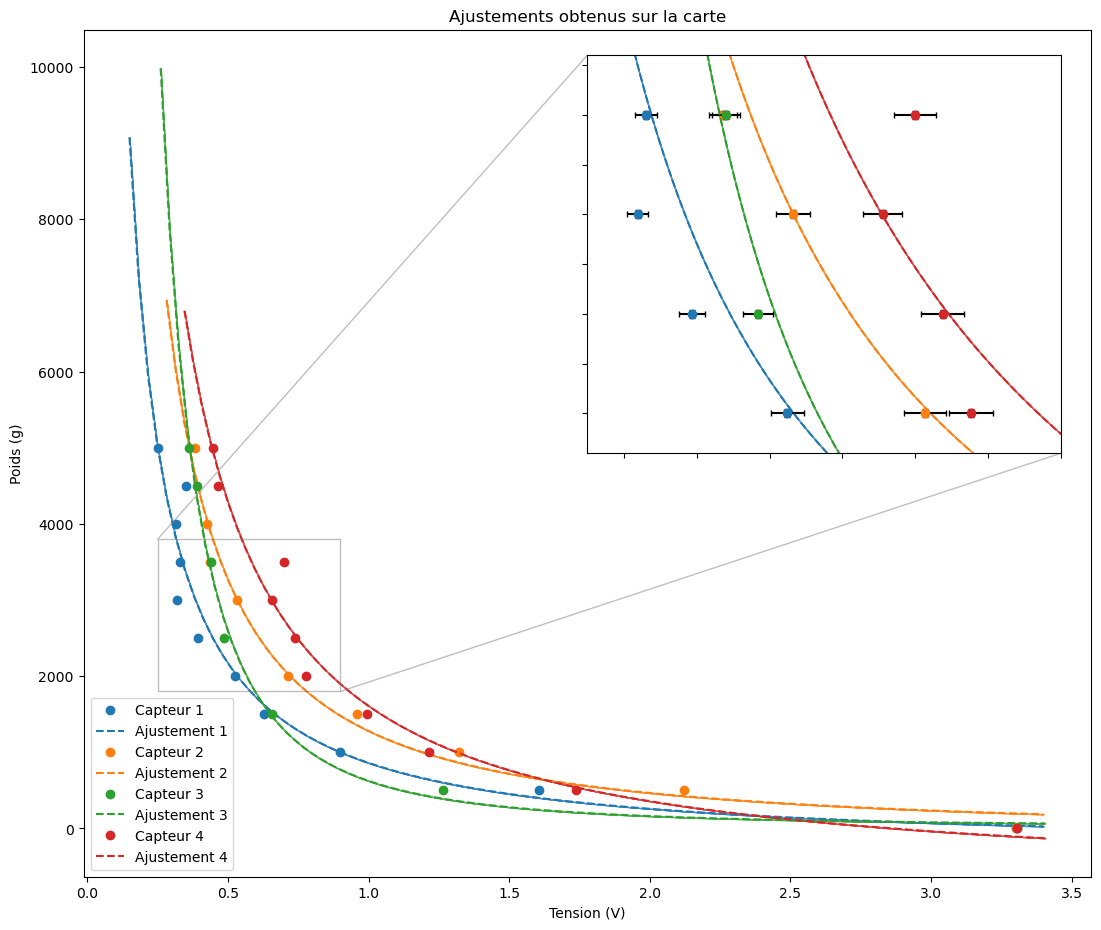

In [129]:
def func(x, a, b,c):
    return a/x**b + c

def calculate_weight_err_mc(u,a,b,c, samples=10**5):
    u_err = calculate_u_err(u, 2.5, 5)
    tab_u = np.random.normal(u, u_err, samples)
    func_tab = func(tab_u, a, b, c)
    return np.std(func_tab, ddof=1)


# Plot the fit
def plot_fit(data, entries):
    fig, ax = plt.subplots()
    for i in range(len(data)):
        a,b,c = entries[i][0]

        x = [d[0] for d in data[i]]
        y = [d[1] for d in data[i]]
        if x == []:
            continue

        ax.plot(x,y,'o', label='Capteur {}'.format(i+1), color='C{}'.format(i))
        ax.set_xlabel('Tension (V)')
        ax.set_ylabel('Poids (g)')
        x = np.linspace(min(x) - 0.1, max(x) + 0.1, 100)

        val_y = func(x, a, b, c)  * entries[i][2] + entries[i][1]


        yerr = np.array([calculate_weight_err_mc(xi, a, b, c) for xi in x])
        ax.fill_between(x, val_y - yerr, val_y + yerr, alpha=0.8, color='C{}'.format(i))

        ax.plot(x, val_y,'--', label='Ajustement {}'.format(i+1), color='C{}'.format(i))

    # Zoom on region of interest using inset axes
    axins = ax.inset_axes([0.5, 0.5, 0.47, 0.47])
    x_min = 0.25
    x_max = 0.9

    for i in range(len(data)):
        a,b,c = entries[i][0]

        x = [d[0] for d in data[i]]
        y = [d[1] for d in data[i]]
        if x == []:
            continue

        xerr = calculate_u_err(np.array(x), 2.5, 5)

        axins.errorbar(x,y, xerr=xerr, yerr=20,fmt='none', ecolor='black', capsize=2)
        axins.plot(x,y,'o', label='Capteur {}'.format(i+1), markersize=4)

        axins.plot(x,y,'o', label='Capteur {}'.format(i+1), color='C{}'.format(i))
        x = np.linspace(x_min-0.1, x_max + 0.1, 100)

        val_y = func(x, a, b, c)  * entries[i][2] + entries[i][1]


        yerr = np.array([calculate_weight_err_mc(xi, a, b, c) for xi in x])
        axins.fill_between(x, val_y - yerr, val_y + yerr, alpha=0.8, color='C{}'.format(i))

        axins.plot(x, val_y,'--', label='Ajustement {}'.format(i+1), color='C{}'.format(i))




    axins.set_xlim(x_min, x_max)

    axins.set_ylim(1800, 3800)
    axins.set_xticklabels('')
    axins.set_yticklabels('')
    ax.indicate_inset_zoom(axins)
    
    
    plt.legend()
    plt.title("Ajustements obtenus sur la carte")
    plt.show()

plot_fit(config[1], config[0])

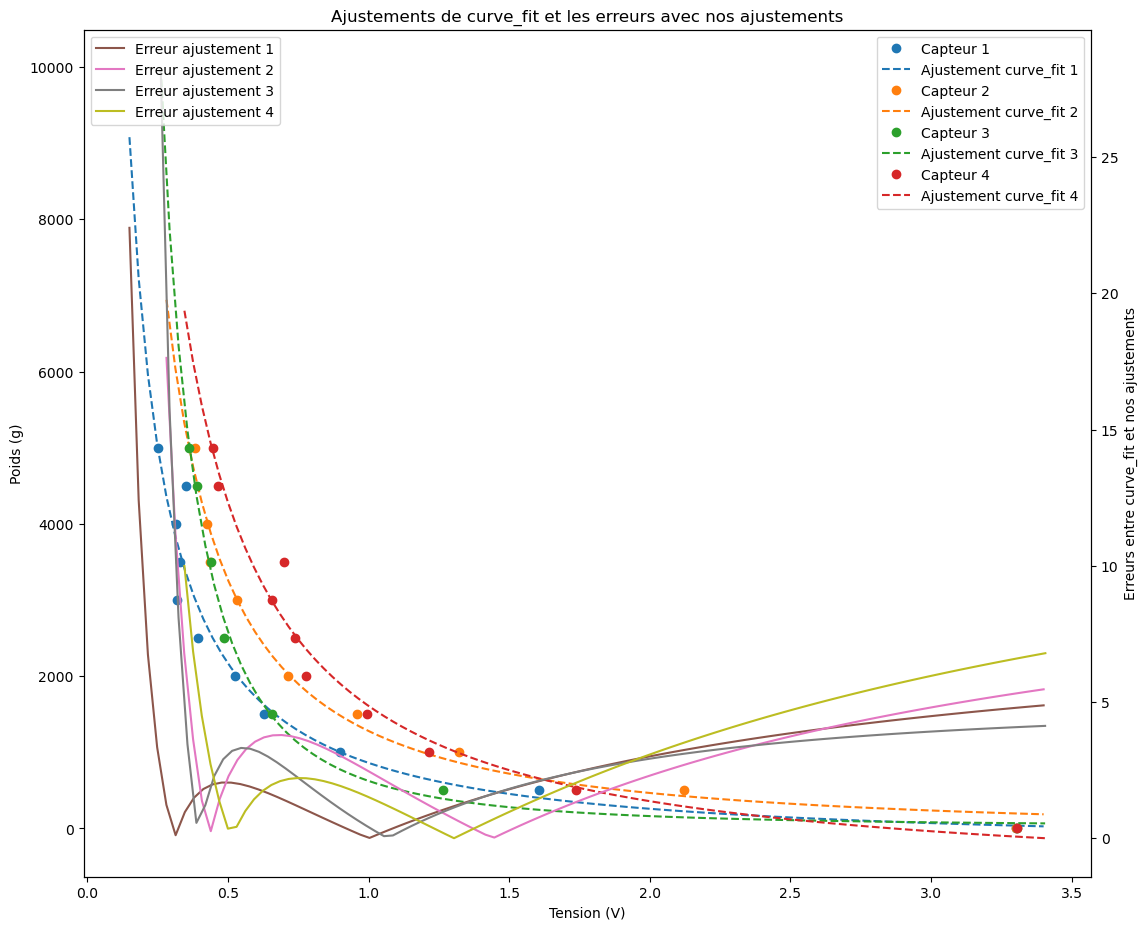

In [89]:
# Plot fit using scipy curve_fit and plot the error bewteen the two fits using antoher axis
def plot_fit_scipy(data, entries):
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    for i in range(len(data)):
        x = [d[0] for d in data[i]]
        y = [d[1] for d in data[i]]
        if x == []:
            continue
        ax1.plot(x,y,'o', label='Capteur {}'.format(i+1), color='C{}'.format(i))
        ax1.set_xlabel('Tension (V)')
        ax1.set_ylabel('Poids (g)')
        popt, pcov = curve_fit(func, x, y)
        x = np.linspace(min(x) - 0.1, max(x) + 0.1, 100)
        ax1.plot(x, func(np.array(x), *entries[i][0])  * entries[i][2] + entries[i][1],'--', label='Ajustement curve_fit {}'.format(i+1), color='C{}'.format(i))
        # plot the error between the two fits
        error = func(np.array(x), *entries[i][0])  * entries[i][2] + entries[i][1] - func(np.array(x), *popt)
        ax2.plot(x, np.abs(error), label='Erreur ajustement {}'.format(i+1), color='C{}'.format(i + len(data)  + 1))
    ax2.set_ylabel('Erreurs entre curve_fit et nos ajustements')
    ax1.legend()
    ax2.legend(loc = "upper left")
    plt.title("Ajustements de curve_fit et les erreurs avec nos ajustements")
    plt.show()

plot_fit_scipy(config[1], config[0])

In [90]:
# Get value at 3.3V for each sensor with fit from config.txt
def get_value_at_3_3(entries):
    for i in range(len(entries)):
        print("Capteur {}: {}g".format(i+1, func(3.306, *entries[i][0]) * entries[i][2] + entries[i][1]))

get_value_at_3_3(config[0])

Capteur 1: 36.87326537697527g
Capteur 2: 196.56077993556391g
Capteur 3: 69.57393365892813g
Capteur 4: -107.74544894369183g
